In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [41]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes1 = [Mode(180., shift)]
modes3 = [Mode(180., shift), Mode(170., shift)]
mols = [
        Molecule(modes1, 3, [12500., 12710.]),
        Molecule(modes1, 3, [12500., 12690.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 200
    aggCore.coupling[mol_i+1, mol_i] = 200
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)

Ham_sys_lambda, Ham_sys_S = eigen(Ham_sys.data)
Ham_sys_Sinv = inv(Ham_sys_S)
Ham_sys_lambda = diagm(Ham_sys_lambda)
indicesLen

27

In [56]:
t_max = 0.02
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 #+ 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [57]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time _, rho_int_t = QME_sI_ansatz_test(
    W0,
    tspan,
    agg;
    reltol = 1e-9,
    abstol = 1e-9,
    int_reltol = 1e-10,
    int_abstol = 1e-10,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

  8.147482 seconds (23.84 M allocations: 2.668 GiB, 3.31% gc time)


([0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009  …  0.0191, 0.0192, 0.0193, 0.0194, 0.0195, 0.0196, 0.0197, 0.0198, 0.0199, 0.02], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im       0.0+0.0im      0.0+0.0im
 0.0+0.0im  0.799839+0.0im      0.0+0.0im
 0.0+0.0im       0.0+0.0im  0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                   0.0+0.0im
 0.0+0.0im      0.799839+0.0im          -1.65313e-12-2.89727e-12im
 0.0+0.0im  -1.65313e-12+2.89727e-12im       0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im      0.799839+0.0im         -6.57615e-12-2.3093e-11im
 0.0+0.0im  -6.57615e-12+2.3093e-11im       0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                   0.0+0.0im
 0.0+0.0im      0.799839+0.0im        

In [63]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time _, rho_int_t2 = QME_sI_ansatz_linear(
    W0,
    tspan,
    agg;
    reltol = 1e-9,
    abstol = 1e-9,
    int_reltol = 1e-10,
    int_abstol = 1e-10,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

 16.590911 seconds (25.53 M allocations: 3.462 GiB, 2.76% gc time, 1.78% compilation time)


([0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009  …  0.0191, 0.0192, 0.0193, 0.0194, 0.0195, 0.0196, 0.0197, 0.0198, 0.0199, 0.02], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im       0.0+0.0im      0.0+0.0im
 0.0+0.0im  0.799839+0.0im      0.0+0.0im
 0.0+0.0im       0.0+0.0im  0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                   0.0+0.0im
 0.0+0.0im      0.799839+0.0im          -1.65313e-12-2.89727e-12im
 0.0+0.0im  -1.65313e-12+2.89727e-12im       0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im      0.799839+0.0im         -6.57615e-12-2.3093e-11im
 0.0+0.0im  -6.57615e-12+2.3093e-11im       0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                   0.0+0.0im
 0.0+0.0im      0.799839+0.0im        

In [64]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    U_0_op = evolutionOperator(Ham_0, t)
    W = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 1.333576037313873e-16
3 1.0752413179624409e-13
4 2.337556721620939e-13
5 2.328327332936919e-13
6 1.05468532000135e-13
7 6.403989545099996e-14
8 1.7035950197235576e-13
9 1.4920593466362063e-13
10 3.743315566437274e-14
11 1.264939251332048e-13
12 1.1298816394082941e-12
13 2.478439531468572e-12
14 3.6222932114133655e-12
15 4.254577306178971e-12
16 4.263458741229866e-12
17 3.685120402491765e-12
18 2.66025598433333e-12
19 1.3987771353804109e-12
20 2.6593679644591823e-13
21 1.0331436640049853e-12
22 1.7327899210157506e-12
23 1.9641768949482424e-12
24 1.7142313158021228e-12
25 1.099178960541933e-12
26 3.728224381419768e-13
27 7.161371403470956e-14
28 8.098993850900089e-13
29 3.2516096320221995e-12
30 6.306062790745345e-12
31 9.212814948557015e-12
32 1.1410131275106218e-11
33 1.2523142927844821e-11
34 1.2365542606708461e-11
35 1.0903641851155812e-11
36 8.262159217129828e-12
37 4.716526853879043e-12
38 1.5317479550494356e-12
39 4.65627855913385e-12
40 8.927631497325846e-12
41 1.26898299

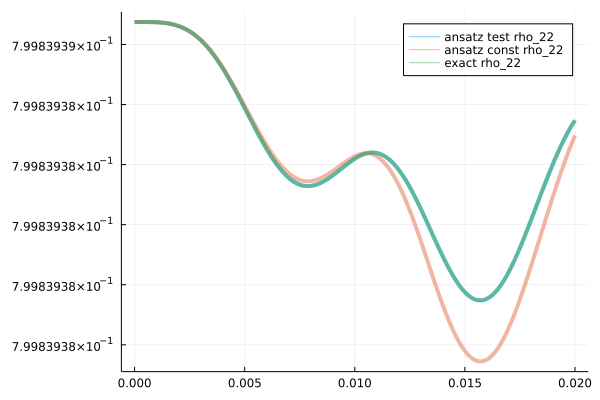

In [65]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t2 = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho_t[t_i, :, :] = rho_int_t[t_i].data
    rho_t2[t_i, :, :] = rho_int_t2[t_i].data
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="ansatz test rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t2[:, 2, 2]), label="ansatz const rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

1 0.0
2 1.333576037313873e-16
3 1.0752413179624409e-13
4 2.337556721620939e-13
5 2.328327332936919e-13
6 1.05468532000135e-13
7 6.403989545099996e-14
8 1.7035950197235576e-13
9 1.4920593466362063e-13
10 3.743315566437274e-14
11 1.264939251332048e-13
12 1.1298816394082941e-12
13 2.478439531468572e-12
14 3.6222932114133655e-12
15 4.254577306178971e-12
16 4.263458741229866e-12
17 3.685120402491765e-12
18 2.66025598433333e-12
19 1.3987771353804109e-12
20 2.6593679644591823e-13
21 1.0331436640049853e-12
22 1.7327899210157506e-12
23 1.9641768949482424e-12
24 1.7142313158021228e-12
25 1.099178960541933e-12
26 3.728224381419768e-13
27 7.161371403470956e-14
28 8.098993850900089e-13
29 3.2516096320221995e-12
30 6.306062790745345e-12
31 9.212814948557015e-12
32 1.1410131275106218e-11
33 1.2523142927844821e-11
34 1.2365542606708461e-11
35 1.0903641851155812e-11
36 8.262159217129828e-12
37 4.716526853879043e-12
38 1.5317479550494356e-12
39 4.65627855913385e-12
40 8.927631497325846e-12
41 1.26898299

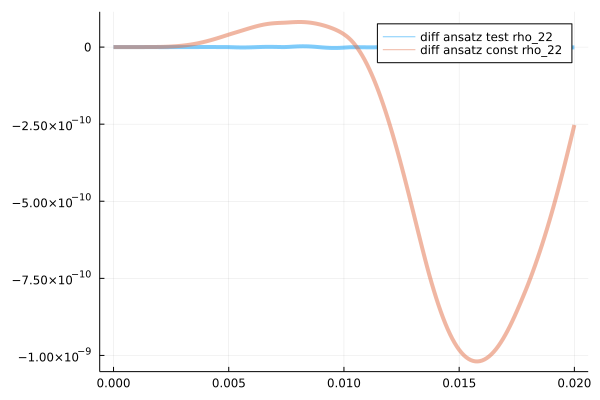

In [66]:
elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t2 = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho_t[t_i, :, :] = rho_int_t[t_i].data
    rho_t2[t_i, :, :] = rho_int_t2[t_i].data
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2] - rho_t_exact[:, 2, 2]), label="diff ansatz test rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t2[:, 2, 2] - rho_t_exact[:, 2, 2]), label="diff ansatz const rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

(27, 27)
1 0.0
2 1.1183586138957907e-16
3 1.0749979981265963e-13
4 2.337490149632213e-13
5 2.327819212789805e-13
6 1.0544858061378267e-13
7 6.40562745811048e-14
8 1.7035363738303665e-13
9 1.4916104250255458e-13
10 3.739032621931882e-14
11 1.2648965576930818e-13
12 1.1298426401694725e-12
13 2.4784331593533102e-12
14 3.622208906868364e-12
15 4.25450396181111e-12
16 4.263409368258465e-12
17 3.685137044853766e-12
18 2.6602435569288804e-12
19 1.3987580685260022e-12
20 2.658981616132653e-13
21 1.0331287169546446e-12
22 1.732789667964026e-12
23 1.964130850311393e-12
24 1.7142199681643187e-12
25 1.0991926889562036e-12
26 3.728236852330445e-13
27 7.159857250708558e-14
28 8.099317330255892e-13
29 3.25155280916513e-12
30 6.306120362808141e-12
31 9.212836927403926e-12
32 1.1410226053217284e-11
33 1.2523105370295445e-11
34 1.2365551970924691e-11
35 1.0903611133738978e-11
36 8.262107700289369e-12
37 4.7165911986772745e-12
38 1.531751698713228e-12
39 4.656276858033276e-12
40 8.927676010816876e-12
41 

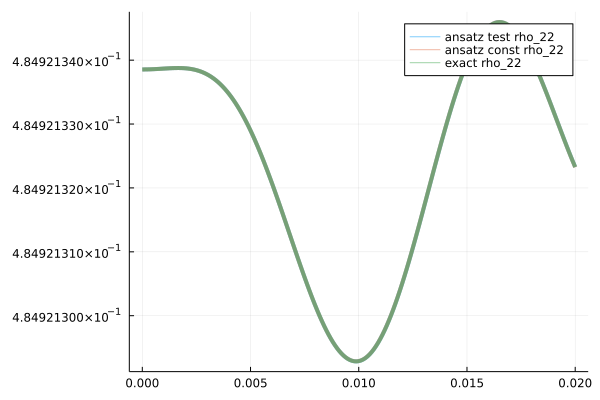

In [67]:
elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t2 = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
println(size(Ham_0_Sinv))
for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham_sys, t)
    rho_t[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho_int_t[t_i].data * U_op.data * Ham_sys_S
    rho_t2[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho_int_t2[t_i].data * U_op.data * Ham_sys_S
    rho = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    rho_t_exact[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho * U_op.data * Ham_sys_S
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 1, 1]), label="ansatz test rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t2[:, 1, 1]), label="ansatz const rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 1, 1]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [68]:
using OpenQuantumSystems
include("test_master_ansatz.jl")


Test Summary: |
master ansatz | No tests


Test.DefaultTestSet("master ansatz", Any[], 0, false, false)

In [71]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   33     33
Test Summary:       | Pass  Total
interaction picture |   12     12
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
